In [494]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

In [495]:
import glob
import os
import PIL
import time

from IPython import display

In [496]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [497]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [498]:
generator = make_generator_model()
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [499]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [500]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

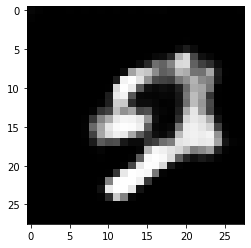

In [501]:
noi = tf.random.normal([1, 100])
sample = checkpoint.generator(noi, training=False)
plt.imshow(sample[0, :, :, 0], cmap='gray')

In [502]:
disc = checkpoint.discriminator
disc.summary()

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_113 (LeakyReLU)  (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_114 (LeakyReLU)  (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 6272)            

In [503]:
val = disc(sample)
print (val)

tf.Tensor([[-0.652002]], shape=(1, 1), dtype=float32)


Now, we transfer the weights of discriminator to a new model, with the only difference being that the new model's last dense layer has 10 parameters instead of 1.

In [504]:
new_model = Sequential()

for i in range(len(disc.layers) - 1):
    new_model.add(disc.layers[i])

# freeze the layers 
for layer in new_model.layers:
    layer.trainable = False    
    
new_model.add(Dense(10, activation='softmax'))
new_model.summary()

Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_113 (LeakyReLU)  (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_114 (LeakyReLU)  (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 6272)            

In [505]:
# view the initialized weights and bias of the last dense layer; weights are uniformly randomly generated 
# and biases are all zeroes by default
new_model.layers[-1].weights

[<tf.Variable 'dense_68/kernel:0' shape=(6272, 10) dtype=float32, numpy=
 array([[-0.01251988,  0.00992047,  0.00985532, ...,  0.0267175 ,
          0.00675382, -0.01282704],
        [-0.00616923,  0.02997103,  0.03005369, ..., -0.00873856,
          0.0048786 ,  0.02359979],
        [ 0.0134477 ,  0.00093581, -0.01567984, ...,  0.03086808,
          0.01211554, -0.01863792],
        ...,
        [-0.02907815, -0.00998354,  0.00620069, ...,  0.03027847,
          0.02443405, -0.00629715],
        [ 0.00384514, -0.01022158,  0.01402976, ..., -0.00706678,
         -0.02982565, -0.02726202],
        [-0.01532045,  0.00947233, -0.02702774, ...,  0.02299141,
         -0.00859891, -0.02178914]], dtype=float32)>,
 <tf.Variable 'dense_68/bias:0' shape=(10,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>]

In [506]:
(train_img, train_lb), (test_img, test_lb) = tf.keras.datasets.mnist.load_data()

print(train_img.shape, train_lb.shape, test_img.shape, test_lb.shape, '\n')

# set random seed
np.random.seed(42)
trainsize = 10000  # number of training images we use, selected randomly
randtrain = np.random.choice(train_img.shape[0], trainsize, replace=False)
X_train, y_train = train_img[randtrain], train_lb[randtrain]

np.random.seed(10)
testsize = 10000  # number of testing images we use, selected randomly
randtest = np.random.choice(test_img.shape[0], testsize, replace=False)
X_test, y_test = test_img[randtest], test_lb[randtest]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,) 

(10000, 28, 28) (10000,) (10000, 28, 28) (10000,)


In [507]:
X_train[-2000:].shape

(2000, 28, 28)

In [508]:
train_images = X_train.reshape((trainsize, 28, 28, 1))
train_images = (train_images.astype('float32') - 127.5) / 127.5

test_images = X_test.reshape((testsize, 28, 28, 1))
test_images = (test_images.astype('float32') - 127.5) / 127.5

train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

new_model.compile(optimizer='sgd',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history1 = new_model.fit(train_images, train_labels, batch_size=100, epochs=5,
                        validation_data=(test_images, test_labels))


Epoch 1/5
100/100 [==============================] - 4s 43ms/step - loss: 1.6821 - accuracy: 0.5793 - val_loss: 1.2098 - val_accuracy: 0.7857
Epoch 2/5
100/100 [==============================] - 5s 51ms/step - loss: 1.0581 - accuracy: 0.7864 - val_loss: 0.8799 - val_accuracy: 0.8295
Epoch 3/5
100/100 [==============================] - 6s 61ms/step - loss: 0.8388 - accuracy: 0.8207 - val_loss: 0.7308 - val_accuracy: 0.8559
Epoch 4/5
100/100 [==============================] - 6s 59ms/step - loss: 0.7243 - accuracy: 0.8413 - val_loss: 0.6449 - val_accuracy: 0.8653
Epoch 5/5
100/100 [==============================] - 6s 63ms/step - loss: 0.6502 - accuracy: 0.8518 - val_loss: 0.5877 - val_accuracy: 0.8718


In [509]:
# unfreeze all layers 
for layer in new_model.layers:
    layer.trainable = True

# optimizer=new_model.optimizer
# optimizer.learning_rate=0.005
    
new_model.compile(optimizer='sgd',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history2 = new_model.fit(train_images, train_labels, batch_size=100, epochs=10,
                        validation_data=(test_images, test_labels)) 


Epoch 1/10
100/100 [==============================] - 11s 111ms/step - loss: 0.5129 - accuracy: 0.8635 - val_loss: 0.4259 - val_accuracy: 0.8837
Epoch 2/10
100/100 [==============================] - 12s 115ms/step - loss: 0.4426 - accuracy: 0.8697 - val_loss: 0.3863 - val_accuracy: 0.8912
Epoch 3/10
100/100 [==============================] - 11s 115ms/step - loss: 0.4077 - accuracy: 0.8793 - val_loss: 0.3617 - val_accuracy: 0.8954
Epoch 4/10
100/100 [==============================] - 11s 114ms/step - loss: 0.3818 - accuracy: 0.8839 - val_loss: 0.3433 - val_accuracy: 0.9002
Epoch 5/10
100/100 [==============================] - 11s 112ms/step - loss: 0.3646 - accuracy: 0.8925 - val_loss: 0.3273 - val_accuracy: 0.9053
Epoch 6/10
100/100 [==============================] - 11s 112ms/step - loss: 0.3480 - accuracy: 0.8936 - val_loss: 0.3141 - val_accuracy: 0.9100
Epoch 7/10
100/100 [==============================] - 11s 112ms/step - loss: 0.3376 - accuracy: 0.8991 - val_loss: 0.3037 - val_ac

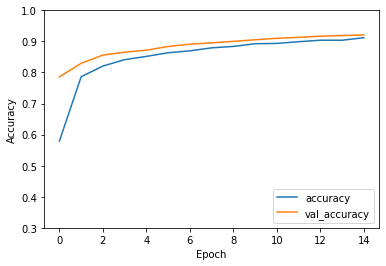

In [510]:
accuracy = history1.history['accuracy'] + history2.history['accuracy']
val_accuracy = history1.history['val_accuracy'] + history2.history['val_accuracy']

plt.figure()
plt.plot(accuracy, label='accuracy')
plt.plot(val_accuracy, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')
plt.show()

We can see that, using the tuned discriminator model, training accuracy and testing are around 0.91 and 0.92 after 15 epochs.

[[2.9793746e-06 3.1210182e-04 9.8530954e-01 1.2565834e-02 2.9811892e-07
  3.1053569e-06 1.3645126e-04 3.3899209e-06 1.6609745e-03 5.3962726e-06]]
prediction: 2


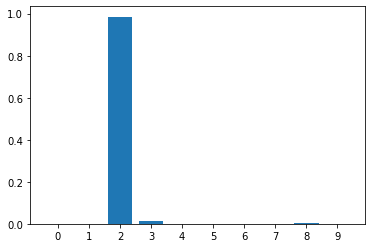

In [511]:
# demonstration: predict the ith test digit
i = 15
prediction = new_model.predict(test_images[i].reshape(1,28,28,1))
# get probability distribution and classification of the test digit
print(prediction)
print('prediction:', np.argmax(prediction))

# draw the barplot
plt.figure()
plt.bar(np.arange(0,10).astype('str'), prediction[0,:])
plt.show()

actual label: 2


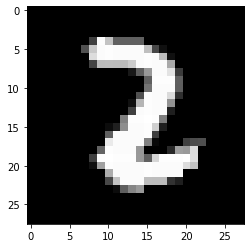

In [512]:
# show the actual ith digit
print('actual label:', np.argmax(test_labels[i]))
plt.figure()
plt.imshow(test_images[i,:,:,0], cmap='gray')
plt.show()

In [513]:
pred_labels = new_model.predict(test_images).argmax(axis=1)
true_labels = test_labels.argmax(axis=1)

In [514]:
confusion_mat = tf.math.confusion_matrix(labels=true_labels, predictions=pred_labels).numpy()
confusion_mat

array([[ 955,    0,    1,    1,    0,    7,   12,    1,    3,    0],
       [   0, 1104,    2,    5,    1,    2,    5,    0,   16,    0],
       [  13,    2,  912,   22,   14,    3,   11,   19,   31,    5],
       [   3,    0,   11,  931,    1,   30,    1,   10,   15,    8],
       [   2,    1,    4,    1,  919,    2,   10,    1,    9,   33],
       [   4,    3,    1,   27,    0,  807,   13,    4,   26,    7],
       [  24,    3,    5,    2,   14,   15,  892,    0,    3,    0],
       [   5,   11,   24,    7,    8,    2,    0,  936,    4,   31],
       [   7,    7,    8,   30,    9,   19,    8,   13,  860,   13],
       [  14,    5,    6,   10,   33,   14,    0,   20,   16,  891]])

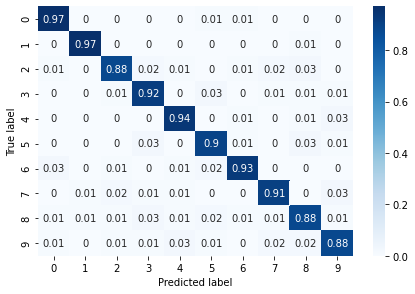

In [515]:
import pandas as pd
import seaborn as sns

confusion_mat_norm = np.around(confusion_mat.astype('float') / np.atleast_2d(confusion_mat.sum(axis=1)).T, decimals=2)

classes = np.arange(0,10).astype('str')
confusion_mat_df = pd.DataFrame(confusion_mat_norm,
                                index = classes, 
                                columns = classes)

figure = plt.figure()
sns.heatmap(confusion_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()